
# Titanic Survival Prediction
This project analyzes the Titanic dataset, performs data cleaning, 
feature engineering, and builds machine learning models 
(Logistic Regression, Random Forest) to predict passenger survival.


### Step 0: Load Libraries
Import all necessary libraries for data handling, visualization, 
preprocessing, and machine learning models.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from scipy.stats import ks_2samp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler




### Step 1: Load Dataset
Read train and test datasets into pandas DataFrames.
These will be used for exploratory analysis, feature engineering, 
and model training/testing.


In [2]:


train = pd.read_csv(r"titanic\train.csv")
test = pd.read_csv(r"titanic\test.csv")

print(train.shape)
print(train.columns)
train.head()


(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Step 2: Exploratory Data Analysis (EDA)
Explore the dataset: inspect structure, missing values, 
distributions, and correlations between features and survival.


In [3]:


# Count missing values ​​in each column
print(train.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


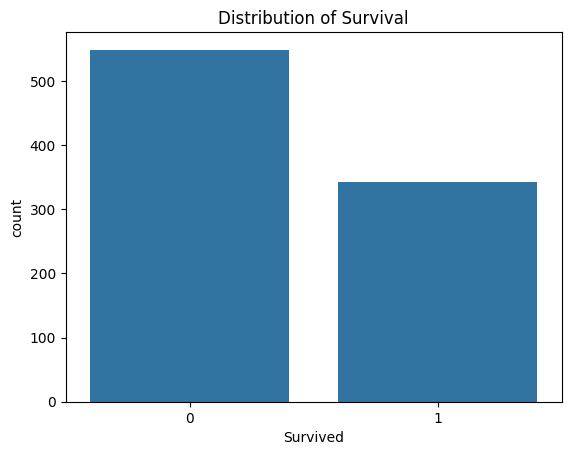

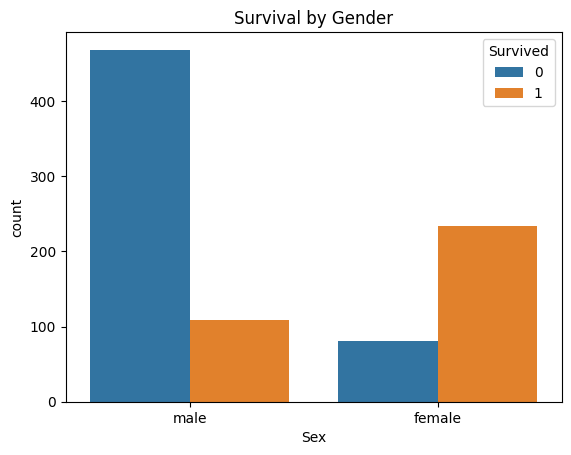

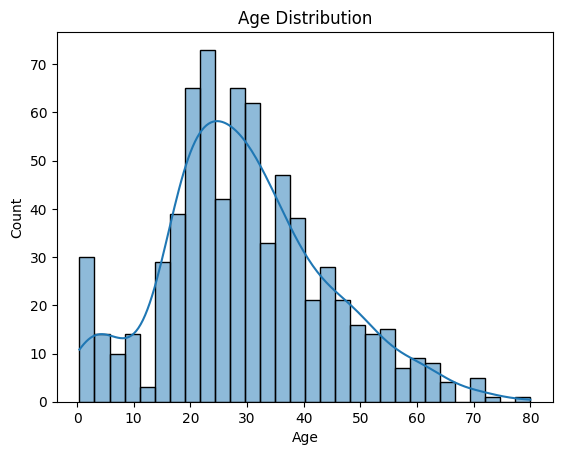

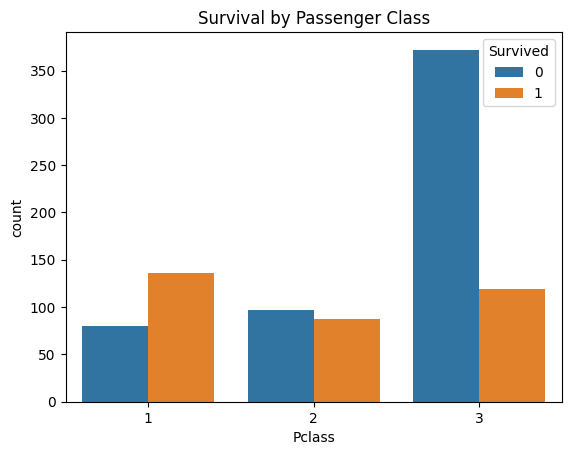

In [4]:


# Distribution of the target variable
sns.countplot(x="Survived", data=train)
plt.title("Distribution of Survival")
plt.show()

# Gender distribution by survival
sns.countplot(x="Sex", hue="Survived", data=train)
plt.title("Survival by Gender")
plt.show()

# Age distribution
sns.histplot(train["Age"].dropna(), bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

# Passenger class vs. survival
sns.countplot(x="Pclass", hue="Survived", data=train)
plt.title("Survival by Passenger Class")
plt.show()


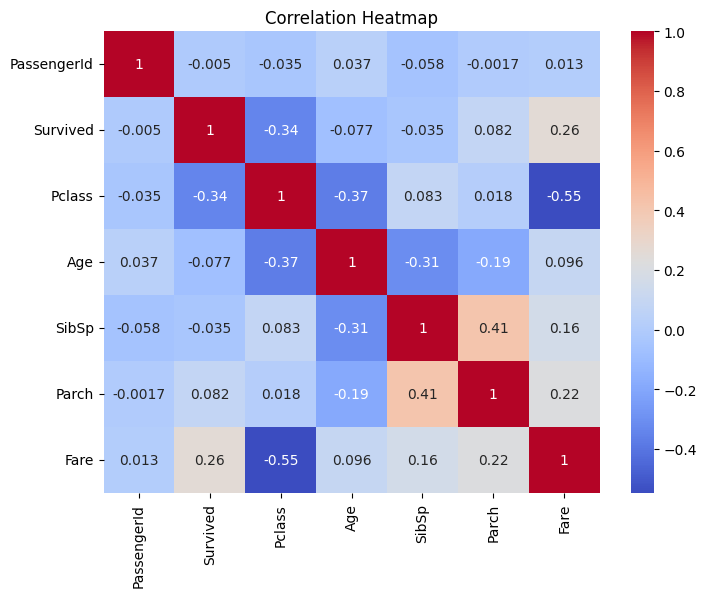

In [5]:
# Correlation matrix
corr = train.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


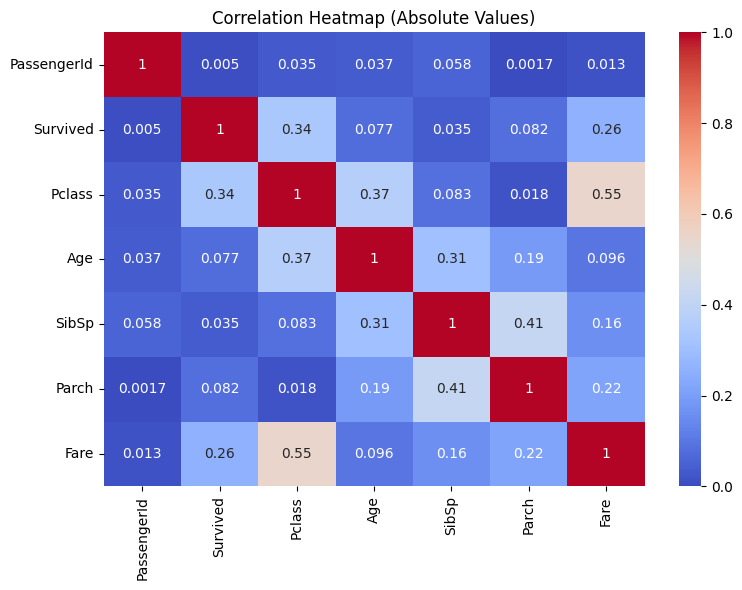

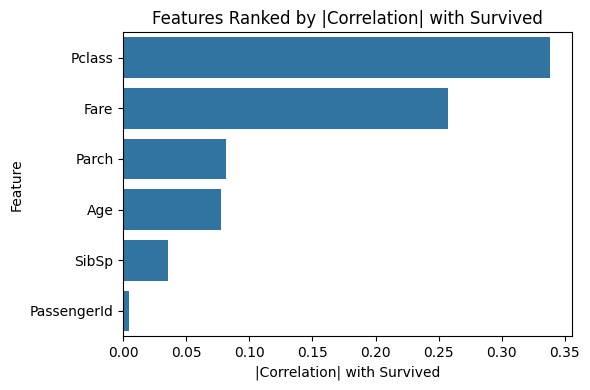

       feature    |corr|  signed_corr
0       Pclass  0.338481    -0.338481
1         Fare  0.257307     0.257307
2        Parch  0.081629     0.081629
3          Age  0.077221    -0.077221
4        SibSp  0.035322    -0.035322
5  PassengerId  0.005007    -0.005007


In [6]:


# Correlation (numeric features only)
corr = train.corr(numeric_only=True)

# Heatmap with absolute correlation values
corr_abs = corr.abs()

plt.figure(figsize=(8,6))
sns.heatmap(corr_abs, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Correlation Heatmap (Absolute Values)")
plt.tight_layout()
plt.show()

# Ranking correlations (absolute values) with Survived
target = "Survived"
corr_to_target = corr_abs[target].drop(target).sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=corr_to_target.values, y=corr_to_target.index)
plt.xlabel(f"|Correlation| with {target}")
plt.ylabel("Feature")
plt.title(f"Features Ranked by |Correlation| with {target}")
plt.tight_layout()
plt.show()

# Optional: keep both the absolute value and the original sign of the correlation
signed = corr[target].drop(target).reindex(corr_to_target.index)
summary = pd.DataFrame({
    "feature": corr_to_target.index,
    "|corr|": corr_to_target.values,
    "signed_corr": signed.values
})
print(summary)


### Step 3: Handle Missing Values
Fill or impute missing data (Age with model, Embarked with mode, 
drop Cabin). Ensure dataset has no NaNs before training.


In [7]:


# Create a new DataFrame with missing/non-missing valuesניצור DataFrame חדש עם ערכים חסרים/לא חסרים
age_df = train[["Age", "Pclass", "Sex", "SibSp", "Parch", "Fare", "Embarked"]].copy()

# Encoding categorical variables
age_df = pd.get_dummies(age_df, columns=["Sex", "Embarked"], drop_first=True)

# Split into data with known ages and missing ages
known_age = age_df[age_df["Age"].notnull()]
unknown_age = age_df[age_df["Age"].isnull()]

X_train_age = known_age.drop("Age", axis=1)
y_train_age = known_age["Age"]

X_test_age = unknown_age.drop("Age", axis=1)

# Build RandomForest model to predict missing ages
rfr = RandomForestRegressor(n_estimators=200, random_state=42)
rfr.fit(X_train_age, y_train_age)

# Predict missing ages
predicted_ages = rfr.predict(X_test_age)

# Insert the predicted values back into train
train.loc[train["Age"].isnull(), "Age"] = predicted_ages


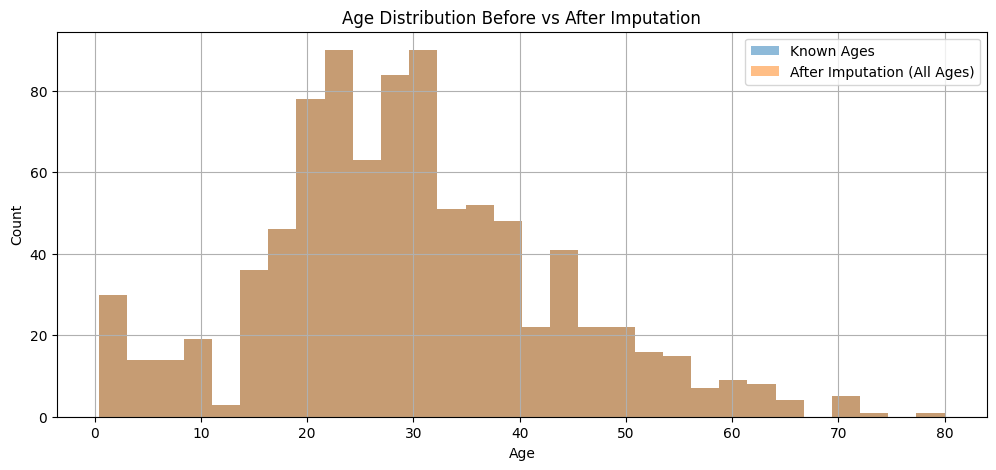

In [8]:


plt.figure(figsize=(12,5))

# Before – only known ages
train["Age"].dropna().hist(bins=30, alpha=0.5, label="Known Ages")

# After – including predicted ages
train["Age"].hist(bins=30, alpha=0.5, label="After Imputation (All Ages)")

plt.legend()
plt.title("Age Distribution Before vs After Imputation")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


In [9]:
imputed_ages = train.loc[train["Age"].isnull(), "Age"]  # If you saved before
print("Sample of predicted ages:")
print(imputed_ages.head(10))


Sample of predicted ages:
Series([], Name: Age, dtype: float64)


== Age distribution stats ==
Before (known only) -> N= 714, mean=29.70, median=28.00, std=14.53
After  (known + imputed) -> N= 891, mean=29.54, median=28.00, std=13.71

KS test: statistic=0.023, p-value=0.983


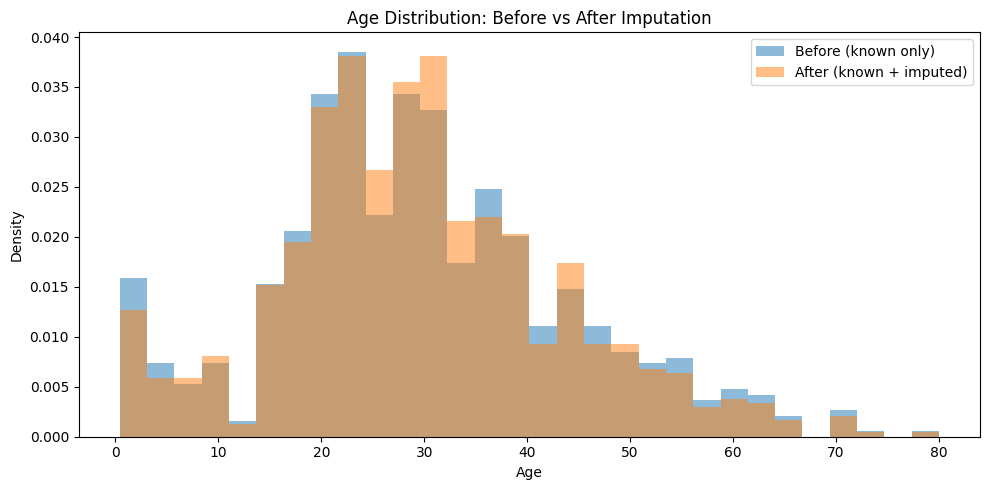


Mean Age by Pclass (Before vs After):
           Before      After
Pclass                      
1       38.233441  38.590865
2       29.877630  30.044664
3       25.140620  25.364261


In [10]:



raw = pd.read_csv(r"titanic\train.csv")
ages_before = raw["Age"].dropna()  # only known ages before imputation
ages_after = train["Age"].dropna() # all ages in the DataFrame after imputation

# Quick statistics
def stats(series, name):
    print(f"{name} -> N={series.shape[0]:>4}, mean={series.mean():.2f}, median={series.median():.2f}, std={series.std():.2f}")

print("== Age distribution stats ==")
stats(ages_before, "Before (known only)")
stats(ages_after,  "After  (known + imputed)")

#  KS-test: check whether the two distributions are statistically similar
ks_stat, p_val = ks_2samp(ages_before, ages_after)
print(f"\nKS test: statistic={ks_stat:.3f}, p-value={p_val:.3f}")

# Visualization: overlapping histograms
plt.figure(figsize=(10,5))
plt.hist(ages_before, bins=30, density=True, alpha=0.5, label="Before (known only)")
plt.hist(ages_after,  bins=30, density=True, alpha=0.5, label="After (known + imputed)")
plt.title("Age Distribution: Before vs After Imputation")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# mean age by class before/after (helps assess whether the imputation blends in logically)
before_by_pclass = raw.dropna(subset=["Age"]).groupby("Pclass")["Age"].mean()
after_by_pclass  = train.groupby("Pclass")["Age"].mean()

print("\nMean Age by Pclass (Before vs After):")
print(pd.DataFrame({"Before": before_by_pclass, "After": after_by_pclass}))


C:\Users\lians\AppData\Local\Temp\ipykernel_23604\3017335846.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival = train.groupby(["AgeGroup", "Survived"]).size().unstack(fill_value=0)


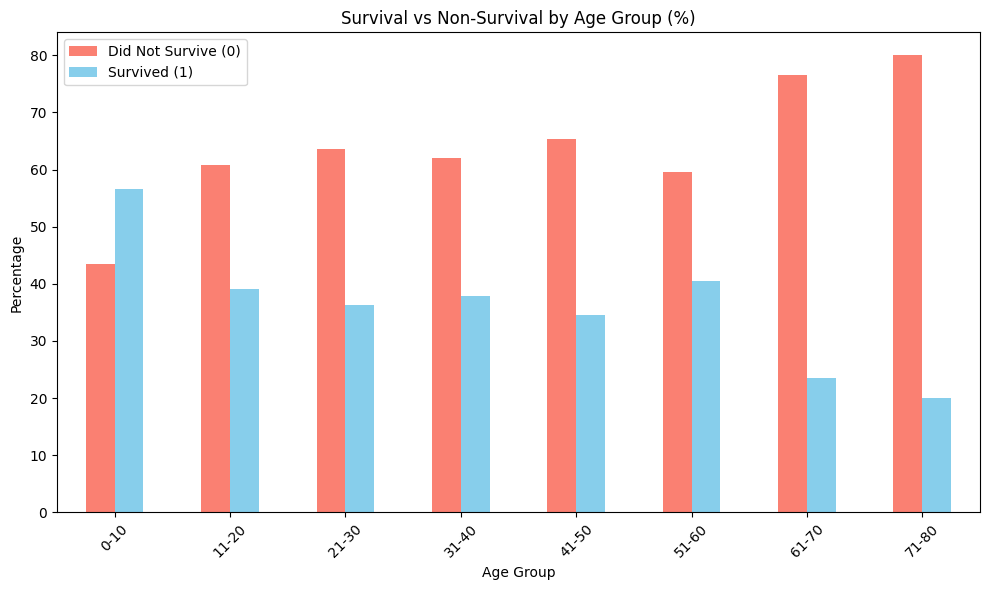

Survived      0      1
AgeGroup              
0-10      43.48  56.52
11-20     60.87  39.13
21-30     63.67  36.33
31-40     62.09  37.91
41-50     65.38  34.62
51-60     59.57  40.43
61-70     76.47  23.53
71-80     80.00  20.00


In [11]:


# Divide into age groups
train["AgeGroup"] = pd.cut(train["Age"], 
                           bins=[0,10,20,30,40,50,60,70,80], 
                           labels=["0-10","11-20","21-30","31-40","41-50","51-60","61-70","71-80"])

# Calculate survival vs non-survival counts for each age group
age_survival = train.groupby(["AgeGroup", "Survived"]).size().unstack(fill_value=0)

# Convert counts to percentages
age_survival_percent = age_survival.div(age_survival.sum(axis=1), axis=0) * 100

#  Plot the results
age_survival_percent.plot(kind="bar", stacked=False, figsize=(10,6), color=["salmon","skyblue"])

plt.title("Survival vs Non-Survival by Age Group (%)")
plt.xlabel("Age Group")
plt.ylabel("Percentage")
plt.legend(["Did Not Survive (0)", "Survived (1)"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the table with numeric percentages
print(age_survival_percent.round(2))



In [12]:
# Remove AgeGroup if it exists
if "AgeGroup" in train.columns:
    train = train.drop(columns=["AgeGroup"])
if "AgeGroup" in test.columns:
    test = test.drop(columns=["AgeGroup"])



In [13]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0000,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0000,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0000,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0000,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0000,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,15.8985,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0000,0,0,111369,30.0000,C148,C


In [14]:
# Drop the Cabin column
train = train.drop("Cabin", axis=1)

# Fill missing Embarked values with the most frequent value
most_freq_embarked = train["Embarked"].mode()[0]
train["Embarked"] = train["Embarked"].fillna(most_freq_embarked)

print("ערך Embarked הנפוץ ביותר:", most_freq_embarked)
print(train["Embarked"].value_counts())


ערך Embarked הנפוץ ביותר: S
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


In [15]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0000,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0000,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0000,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0000,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0000,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0000,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,15.8985,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0000,0,0,111369,30.0000,C


### Step 4: Feature Engineering
Create new features to improve model performance:
- Extract **Title** from `Name`
- Create **FamilySize** = `SibSp + Parch + 1`
- Create **IsAlone** (1 if passenger travels alone, else 0)


In [16]:
for df in (train, test):
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

In [17]:
# FamilySize = number of family members traveling together (including the passenger)
for df in (train, test):
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1



C:\Users\lians\AppData\Local\Temp\ipykernel_23604\2797341328.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="FamilySize", data=train, palette="Set2")


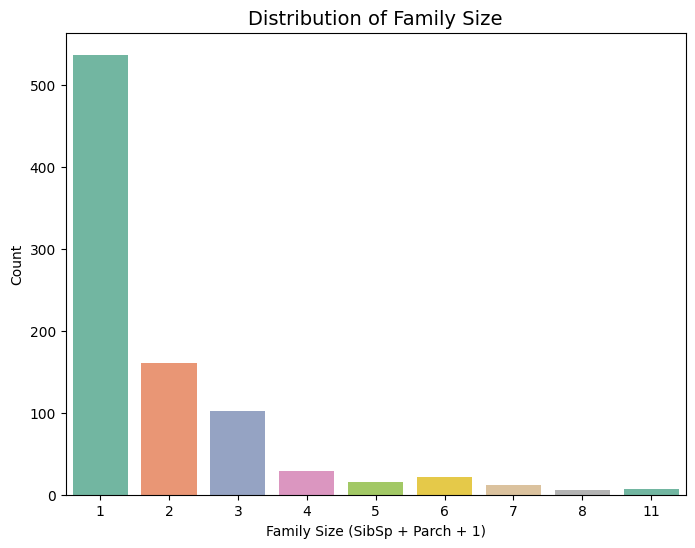

In [18]:


# Distribution of FamilySize
plt.figure(figsize=(8,6))
sns.countplot(x="FamilySize", data=train, palette="Set2")
plt.title("Distribution of Family Size", fontsize=14)
plt.xlabel("Family Size (SibSp + Parch + 1)")
plt.ylabel("Count")
plt.show()



In [19]:
# IsAlone = 1 if the passenger is alone, otherwise 0
for df in (train, test):
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)


In [20]:
# Extract Title from Name (if Name column exists)
def _extract_title(s):
    return s.split(",")[1].split(".")[0].strip()

if "Name" in train.columns and "Name" in test.columns:
    train["Title"] = train["Name"].apply(_extract_title)
    test["Title"]  = test["Name"].apply(_extract_title)
else:
    tr_raw = pd.read_csv("train.csv")[["PassengerId","Name"]]
    te_raw = pd.read_csv("test.csv")[["PassengerId","Name"]]
    tr_titles = tr_raw.assign(Title=tr_raw["Name"].apply(_extract_title)).set_index("PassengerId")["Title"]
    te_titles = te_raw.assign(Title=te_raw["Name"].apply(_extract_title)).set_index("PassengerId")["Title"]
    train["Title"] = train["PassengerId"].map(tr_titles)
    test["Title"]  = test["PassengerId"].map(te_titles)


In [21]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0000,1,0,A/5 21171,7.2500,S,2,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0000,1,0,PC 17599,71.2833,C,2,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0000,0,0,STON/O2. 3101282,7.9250,S,1,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0000,1,0,113803,53.1000,S,2,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0000,0,0,373450,8.0500,S,1,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0000,0,0,211536,13.0000,S,1,1,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0000,0,0,112053,30.0000,S,1,1,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,15.8985,1,2,W./C. 6607,23.4500,S,4,0,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0000,0,0,111369,30.0000,C,1,1,Mr


In [22]:
# Group rare titles under a single "Rare" category
rare = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
for df in (train, test):
    df["Title"] = df["Title"].replace(rare, "Rare")

# Define categories based on TRAIN only
title_cats = sorted(train["Title"].dropna().unique().tolist())

# Convert to categorical with the same domain, then apply get_dummies consistently
for df in (train, test):
    df["Title"] = pd.Categorical(df["Title"], categories=title_cats)

train = pd.get_dummies(train, columns=["Title"], prefix="Title")
test  = pd.get_dummies(test,  columns=["Title"], prefix="Title")

# Ensure all Title columns present in train also exist in test
for col in [c for c in train.columns if c.startswith("Title_")]:
    if col not in test.columns:
        test[col] = 0


In [23]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,IsAlone,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Title_the Countess
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0000,1,0,A/5 21171,7.2500,...,0,False,False,False,False,True,False,False,False,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0000,1,0,PC 17599,71.2833,...,0,False,False,False,False,False,True,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0000,0,0,STON/O2. 3101282,7.9250,...,1,False,True,False,False,False,False,False,False,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0000,1,0,113803,53.1000,...,0,False,False,False,False,False,True,False,False,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0000,0,0,373450,8.0500,...,1,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0000,0,0,211536,13.0000,...,1,False,False,False,False,False,False,False,True,False
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0000,0,0,112053,30.0000,...,1,False,True,False,False,False,False,False,False,False
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,15.8985,1,2,W./C. 6607,23.4500,...,0,False,True,False,False,False,False,False,False,False
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0000,0,0,111369,30.0000,...,1,False,False,False,False,True,False,False,False,False


### Step 5: Encode & Normalize Data
Convert categorical variables to numeric and scale continuous features:
- **Encoding**:
  - `Sex` → binary (0 = female, 1 = male)
  - `Embarked` → one-hot (`Embarked_C`, `Embarked_Q`, `Embarked_S`)
- **Normalization**:
  - Scale `Age` and `Fare` (e.g., `StandardScaler`) — fit on train only, transform both train and test.


In [24]:


# Sex -> 0/1
train["Sex"] = LabelEncoder().fit_transform(train["Sex"])

# Embarked -> One-Hot Encoding
train = pd.get_dummies(train, columns=["Embarked"], drop_first=True)

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Title_the Countess,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,False,False,False,True,False,False,False,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,False,False,False,False,True,False,False,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,True,False,False,False,False,False,False,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,False,False,False,False,True,False,False,False,False,True
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,False,False,False,True,False,False,False,False,False,True


In [25]:
for df in (train, test):
    df["Pclass_x_Sex"] = df["Pclass"] * df["Sex"]


In [26]:
# Normalize Age
scaler = StandardScaler()

train["Age"] = scaler.fit_transform(train[["Age"]])
test["Age"]  = scaler.transform(test[["Age"]])  # חשוב: transform (בלי fit) כדי למנוע Data Leakage

In [27]:

# Create a new Scaler for Fare
fare_scaler = StandardScaler()

train["Fare"] = fare_scaler.fit_transform(train[["Fare"]])
test["Fare"]  = fare_scaler.transform(test[["Fare"]])  


In [28]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Title_the Countess,Embarked_Q,Embarked_S,Pclass_x_Sex
0,1,0,3,"Braund, Mr. Owen Harris",1,-0.550266,1,0,A/5 21171,-0.502445,...,False,False,True,False,False,False,False,False,True,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.617832,1,0,PC 17599,0.786845,...,False,False,False,True,False,False,False,False,False,0
2,3,1,3,"Heikkinen, Miss. Laina",0,-0.258242,0,0,STON/O2. 3101282,-0.488854,...,False,False,False,False,False,False,False,False,True,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.398814,1,0,113803,0.420730,...,False,False,False,True,False,False,False,False,True,0
4,5,0,3,"Allen, Mr. William Henry",1,0.398814,0,0,373450,-0.486337,...,False,False,True,False,False,False,False,False,True,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,-0.185235,0,0,211536,-0.386671,...,False,False,False,False,False,True,False,False,True,2
887,888,1,1,"Graham, Miss. Margaret Edith",0,-0.769285,0,0,112053,-0.044381,...,False,False,False,False,False,False,False,False,True,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,-0.995713,1,2,W./C. 6607,-0.176263,...,False,False,False,False,False,False,False,False,True,0
889,890,1,1,"Behr, Mr. Karl Howell",1,-0.258242,0,0,111369,-0.044381,...,False,False,True,False,False,False,False,False,False,1


In [29]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Title_the Countess,Embarked_Q,Embarked_S,Pclass_x_Sex
0,1,0,3,"Braund, Mr. Owen Harris",1,-0.550266,1,0,A/5 21171,-0.502445,...,False,False,True,False,False,False,False,False,True,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.617832,1,0,PC 17599,0.786845,...,False,False,False,True,False,False,False,False,False,0
2,3,1,3,"Heikkinen, Miss. Laina",0,-0.258242,0,0,STON/O2. 3101282,-0.488854,...,False,False,False,False,False,False,False,False,True,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.398814,1,0,113803,0.420730,...,False,False,False,True,False,False,False,False,True,0
4,5,0,3,"Allen, Mr. William Henry",1,0.398814,0,0,373450,-0.486337,...,False,False,True,False,False,False,False,False,True,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,-0.185235,0,0,211536,-0.386671,...,False,False,False,False,False,True,False,False,True,2
887,888,1,1,"Graham, Miss. Margaret Edith",0,-0.769285,0,0,112053,-0.044381,...,False,False,False,False,False,False,False,False,True,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,-0.995713,1,2,W./C. 6607,-0.176263,...,False,False,False,False,False,False,False,False,True,0
889,890,1,1,"Behr, Mr. Karl Howell",1,-0.258242,0,0,111369,-0.044381,...,False,False,True,False,False,False,False,False,False,1


In [30]:
def _extract_title(s):
    return s.split(",")[1].split(".")[0].strip()

train["Title"] = train["Name"].apply(_extract_title)
test["Title"]  = test["Name"].apply(_extract_title)



In [31]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Title_the Countess,Embarked_Q,Embarked_S,Pclass_x_Sex,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,-0.550266,1,0,A/5 21171,-0.502445,...,False,True,False,False,False,False,False,True,3,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.617832,1,0,PC 17599,0.786845,...,False,False,True,False,False,False,False,False,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,-0.258242,0,0,STON/O2. 3101282,-0.488854,...,False,False,False,False,False,False,False,True,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.398814,1,0,113803,0.420730,...,False,False,True,False,False,False,False,True,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,0.398814,0,0,373450,-0.486337,...,False,True,False,False,False,False,False,True,3,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,-0.185235,0,0,211536,-0.386671,...,False,False,False,False,True,False,False,True,2,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",0,-0.769285,0,0,112053,-0.044381,...,False,False,False,False,False,False,False,True,0,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,-0.995713,1,2,W./C. 6607,-0.176263,...,False,False,False,False,False,False,False,True,0,Miss
889,890,1,1,"Behr, Mr. Karl Howell",1,-0.258242,0,0,111369,-0.044381,...,False,True,False,False,False,False,False,False,1,Mr


### Step 6: Split Data
 Separate features (X) and target (y), 
 and split into training and validation sets for evaluation.


In [32]:


# Define X (features) and y (target)
X = train.drop(columns=["Survived", "PassengerId", "Name", "Ticket", "Title"], errors="ignore")
y = train["Survived"]

# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)






### Step 7: Run Logistic Regression
- Train a baseline logistic regression model on the training split
- and evaluate it on the validation split (accuracy, precision, recall, F1).
- Uses the same X_train, X_val, y_train, y_val defined earlier.


In [33]:
# 3) Baseline – Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_val)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_val, y_pred_log))
print(classification_report(y_val, y_pred_log))


=== Logistic Regression ===
Accuracy: 0.8491620111731844
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       110
           1       0.85      0.74      0.79        69

    accuracy                           0.85       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



### Step 8: Run Random Forest
- Train a non-linear ensemble model (RandomForestClassifier) on the training split
- and evaluate it on the validation split (accuracy, precision, recall, F1).
- Uses the same X_train, X_val, y_train, y_val for a fair comparison.


In [34]:
# 4) RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))


=== Random Forest ===
Accuracy: 0.8212290502793296
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       110
           1       0.78      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

